In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/dataset3/test-20240621T121517Z-001.zip'

Archive:  /content/drive/MyDrive/dataset3/test-20240621T121517Z-001.zip
  inflating: test/chicken/OIP-8IVGG91ofj4zTmVLlID-bAHaF1.jpeg  
  inflating: test/chicken/546.jpeg   
  inflating: test/chicken/1092.jpeg  
  inflating: test/chicken/OIP-15O0oTR_rhOmv7ALngZKOwHaG-.jpeg  
  inflating: test/chicken/OIP-7ZUE1_8TnH2xGhUODx1VkQHaJG.jpeg  
  inflating: test/chicken/OIP-9pI6oiTbvQWEk4j3LEd3vAHaHt.jpeg  
  inflating: test/chicken/OIP-38Tn9VSTNRN8-TZnMvl1sAHaFj.jpeg  
  inflating: test/chicken/619.jpeg   
  inflating: test/chicken/OIP-7hWtsOaICkVNVrMNczvUPwHaFj.jpeg  
  inflating: test/chicken/162.jpeg   
  inflating: test/chicken/185.jpeg   
  inflating: test/chicken/OIP-7h5ThIQhAh8_qYaeZno93wHaFj.jpeg  
  inflating: test/chicken/OIP-8izNfyQWLo4PfaELbucNWQHaFj.jpeg  
  inflating: test/chicken/1104.jpeg  
  inflating: test/chicken/307.jpeg   
  inflating: test/chicken/236.jpeg   
  inflating: test/chicken/OIP-3amMffZ3ebbHLQMfeilcGwHaFj.jpeg  
  inflating: test/chicken/1096.jpeg  
  inflatin

#1. Khai báo thư viện

In [ ]:
!unzip '/content/drive/MyDrive/dataset3/train-20240621T121616Z-001.zip'

Archive:  /content/drive/MyDrive/dataset3/train-20240621T121616Z-001.zip
  inflating: train/butterfly/OIP-_KpWu9kxE30jovKeO6yMlwHaGP.jpeg  
  inflating: train/butterfly/ea37b30f21fc073ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg  
  inflating: train/butterfly/OIP-1Sd0G-6ou3Ciuxmfdm3sQAHaHa.jpeg  
  inflating: train/butterfly/ea34b20a2ef5013ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg  
  inflating: train/butterfly/OIP-0wlV2OUzauS5VTWx2x3UIAHaFj.jpeg  
  inflating: train/butterfly/ea37b20820f7013ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg  
  inflating: train/butterfly/ea37b80b2ef2023ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg  
  inflating: train/butterfly/OIP-4M7ZOUZQLa1cRCdh6Q0VcgHaHZ.jpeg  
  inflating: train/butterfly/ea37b60f29f7013ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg  
  inflating: train/butterfly/e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg  
  inflating: train/butterfly/ea37b00e2b

In [ ]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Layer
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, Adadelta, SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#2. Thiết lập thông số ảnh

In [ ]:
# Link data
train_dir = '/content/train'
validation_dir = '/content/test'

# Thiết lập ImageDataGenerator cho train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Chuẩn hóa giá trị điểm ảnh của test
validation_datagen = ImageDataGenerator(rescale=1./255)

# Tạo bộ dữ liệu từ các thư mục ảnh
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical'
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


#3. Visualize data

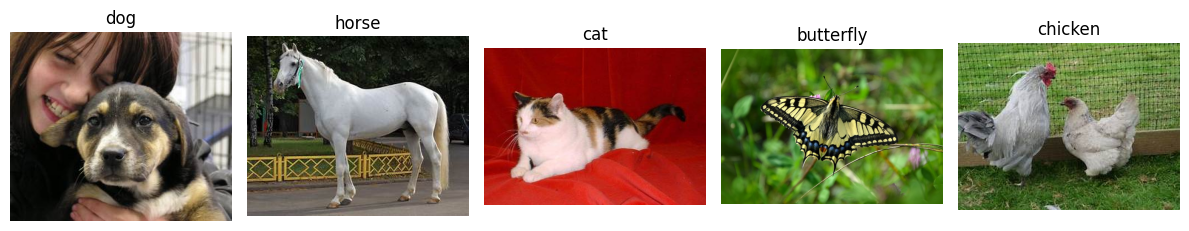

In [ ]:
animal_classes = os.listdir(train_dir)
sample_images = {}
for animal_class in animal_classes:
    class_dir = os.path.join(train_dir, animal_class)
    # Lấy ảnh đầu tiên trong thư mục nhóm động vật này
    image_name = os.listdir(class_dir)[0]
    image_path = os.path.join(class_dir, image_name)
    sample_images[animal_class] = image_path

# Hiển thị ảnh
plt.figure(figsize=(12, 12))
for i, (animal_class, image_path) in enumerate(sample_images.items()):
    plt.subplot(1, 5, i+1)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(animal_class)
    plt.axis('off')
plt.tight_layout()
plt.show()

#4. CNN

##4.1. CNN models

###4.1.1. CNN AlexNet

In [ ]:
model = Sequential([
    # 1st Convolutional Layer
    Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    # 2nd Convolutional Layer
    Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    # 3rd Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
    # 4th Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
    # 5th Convolutional Layer
    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    # Flatten Layer
    Flatten(),
    # 1st Fully Connected Layer
    Dense(4096, activation='relu'),
    Dropout(0.5),
    # 2nd Fully Connected Layer
    Dense(4096, activation='relu'),
    Dropout(0.5),
    # Output Layer
    Dense(5, activation='softmax')  # 5 classes for classification
])

# Mô hình
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 30, 30, 96)        34944     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 14, 14, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_90 (Conv2D)          (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 6, 6, 256)         0         
 ng2D)                                                           
                                                                 
 conv2d_91 (Conv2D)          (None, 6, 6, 384)         885120    
                                                                 
 conv2d_92 (Conv2D)          (None, 6, 6, 384)        

###4.1.2. CNN VGG19

In [ ]:
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

# Convolutional layers
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Flatten và fully connected layers
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

# Mô hình
model = Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_69 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_95 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_70 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 64, 64, 64)        0   

###4.1.3. CNN Resnetblur50


In [ ]:
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

# Convolutional layer đầu tiên với BatchNormalization và MaxPooling
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

def residual_block(x, filters, s=1):
    shortcut = x

    # 1st layer
    x = Conv2D(filters, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # 2nd layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # 3rd layer
    x = Conv2D(4 * filters, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    # Shortcut connection
    if s != 1 or shortcut.shape[-1] != 4 * filters:
        shortcut = Conv2D(4 * filters, kernel_size=(1, 1), strides=(s, s), padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Xây dựng mạng ResNet50 với các residual blocks
x = residual_block(x, filters=64, s=1)
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)

x = residual_block(x, filters=128, s=2)
x = residual_block(x, filters=128)
x = residual_block(x, filters=128)
x = residual_block(x, filters=128)

x = residual_block(x, filters=256, s=2)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)

x = residual_block(x, filters=512, s=2)
x = residual_block(x, filters=512)
x = residual_block(x, filters=512)

# Global Average Pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

# Mô hình
model = Model(inputs, outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_212 (Conv2D)         (None, 64, 64, 64)           9472      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_212 (B  (None, 64, 64, 64)           256       ['conv2d_212[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 64)           0         ['batch_normalization_21

##4.2. Tham số

In [ ]:
learning_rate = 0.001    #0.01, 0.001, 0.0001
epochs = 50   #10, 30, 50
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

##4.3. Optimization + Đánh giá mô hình

###4.3.1. SGD

In [ ]:
# Khởi tạo SGD với momentum
momentum = 0.9

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate, momentum=momentum),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
62/62 [==============================] - 28s 192ms/step - loss: 2.2948 - accuracy: 0.2233 - val_loss: 34.3594 - val_accuracy: 0.1979 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 11s 178ms/step - loss: 1.6762 - accuracy: 0.2853 - val_loss: 1.7153 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 9s 149ms/step - loss: 1.5596 - accuracy: 0.3133 - val_loss: 1.5918 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 11s 174ms/step - loss: 1.5287 - accuracy: 0.3445 - val_loss: 1.5763 - val_accuracy: 0.2792 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 12s 189ms/step - loss: 1.5032 - accuracy: 0.3476 - val_loss: 1.5550 - val_accuracy: 0.3063 - lr: 0.0010
Epoch 6/50
62/62 [==============================] - 11s 178ms/step - loss: 1.4810 - accuracy: 0.3526 - val_loss: 1.4914 - val_accuracy: 0.3729 - lr: 0.0010
Epoch 7/50
62/62 [==============================] - 13s 212ms/st

16/16 [==============================] - 1s 81ms/step - loss: 1.1077 - accuracy: 0.5530
Test accuracy: 55.30%


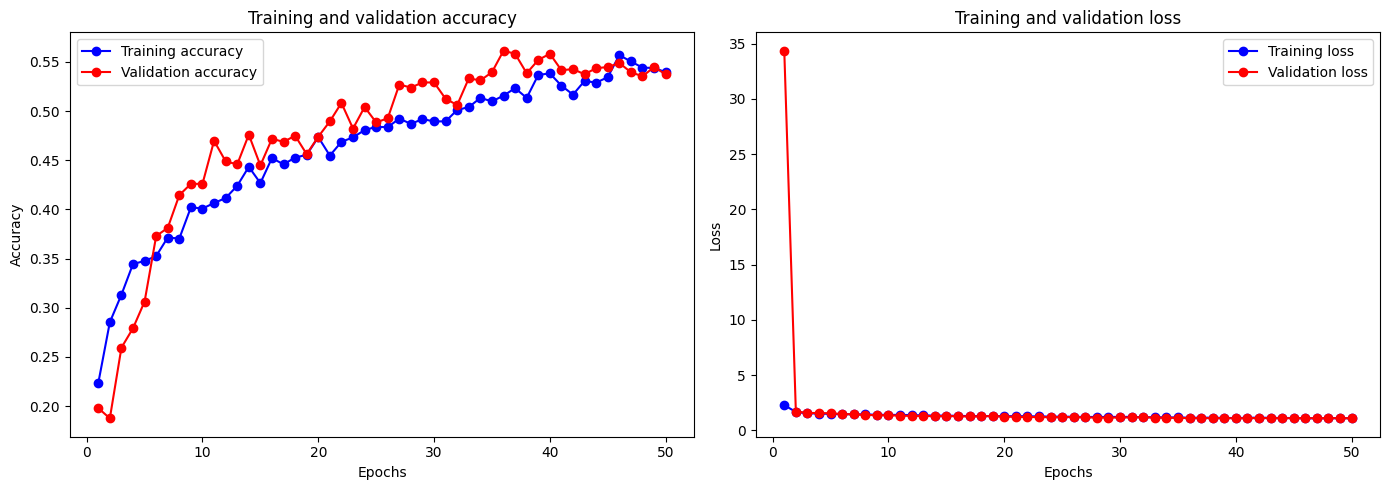

In [ ]:
# Đánh giá mô hình trên tập dữ liệu kiểm thử
loss, accuracy = model.evaluate(validation_generator)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Lấy lịch sử huấn luyện
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Vẽ đồ thị lịch sử huấn luyện accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ đồ thị lịch sử huấn luyện loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

34/34 [==============================] - 8s 220ms/step


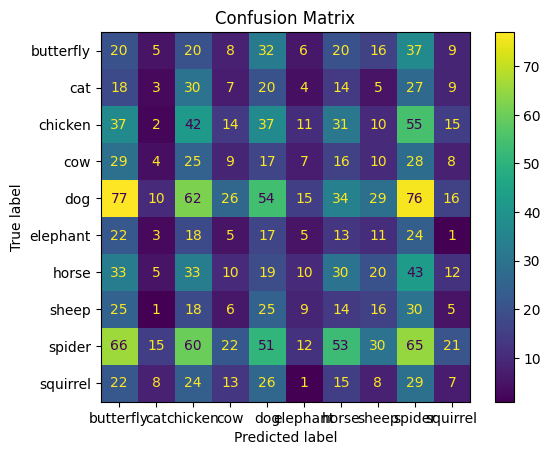

In [ ]:
validation_generator.reset()
test_predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = validation_generator.classes

# Tạo confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Hiển thị confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
cmd.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal')
plt.title('Confusion Matrix')
plt.show()

###4.3.2. Adagrad

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(learning_rate=learning_rate),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
133/133 [==============================] - 126s 940ms/step - loss: 3.6243 - accuracy: 0.1107 - val_loss: 2.4225 - val_accuracy: 0.0578 - lr: 1.0000e-04
Epoch 2/10
133/133 [==============================] - 131s 987ms/step - loss: 3.1604 - accuracy: 0.1353 - val_loss: 2.4455 - val_accuracy: 0.1013 - lr: 1.0000e-04
Epoch 3/10
133/133 [==============================] - 128s 964ms/step - loss: 3.0184 - accuracy: 0.1516 - val_loss: 2.4239 - val_accuracy: 0.1605 - lr: 1.0000e-04
Epoch 4/10
133/133 [==============================] - 130s 980ms/step - loss: 2.8429 - accuracy: 0.1711 - val_loss: 2.3706 - val_accuracy: 0.1979 - lr: 1.0000e-04
Epoch 5/10
133/133 [==============================] - 130s 975ms/step - loss: 2.7628 - accuracy: 0.1708 - val_loss: 2.3878 - val_accuracy: 0.2140 - lr: 1.0000e-04
Epoch 6/10
133/133 [==============================] - 129s 966ms/step - loss: 2.7141 - accuracy: 0.1813 - val_loss: 2.4265 - val_accuracy: 0.2259 - lr: 1.0000e-04
Epoch 7/10
133/133 [==

34/34 [==============================] - 13s 386ms/step - loss: 2.4012 - accuracy: 0.2403
Test accuracy: 24.03%


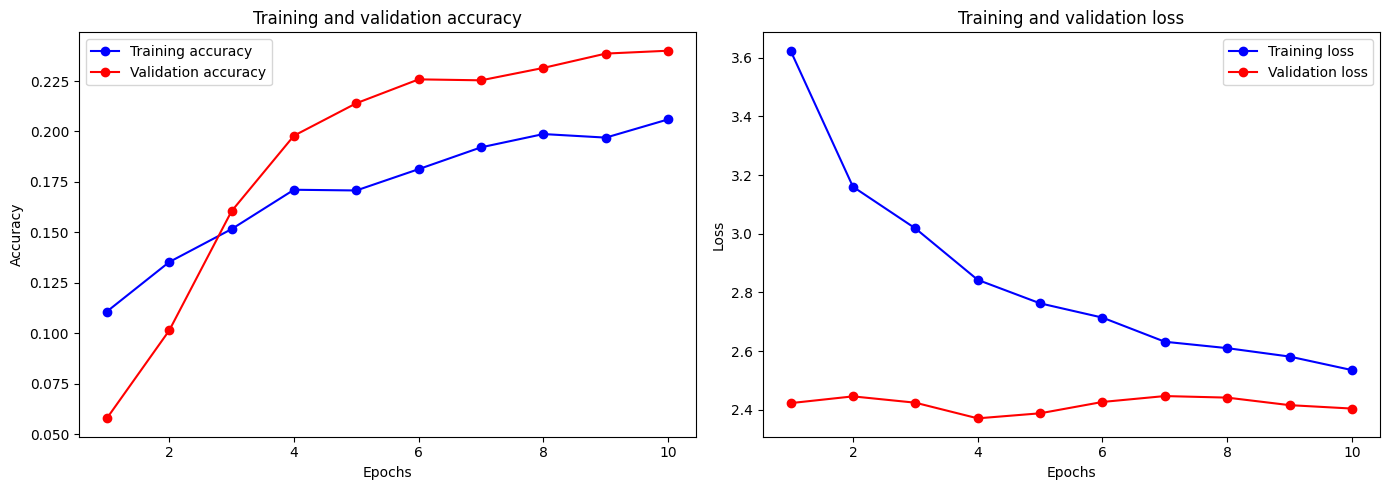

In [ ]:
# Đánh giá mô hình trên tập dữ liệu kiểm thử
loss, accuracy = model.evaluate(validation_generator)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Lấy lịch sử huấn luyện
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Vẽ đồ thị lịch sử huấn luyện accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ đồ thị lịch sử huấn luyện loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

34/34 [==============================] - 15s 445ms/step


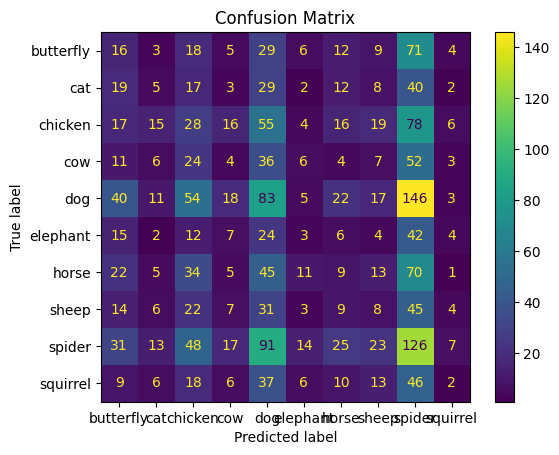

In [ ]:
validation_generator.reset()
test_predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = validation_generator.classes

# Tạo confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Hiển thị confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
cmd.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal')
plt.title('Confusion Matrix')
plt.show()

###4.3.3. Adadelta

In [ ]:
# Khởi tạo Adadelta
learning_rate = 1.0  # Giá trị mặc định cho Adadelta

model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=learning_rate),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
62/62 [==============================] - 39s 193ms/step - loss: 2.4086 - accuracy: 0.2614 - val_loss: 1.6207 - val_accuracy: 0.2083 - lr: 1.0000
Epoch 2/50
62/62 [==============================] - 10s 153ms/step - loss: 1.5428 - accuracy: 0.3204 - val_loss: 1.6257 - val_accuracy: 0.1958 - lr: 1.0000
Epoch 3/50
62/62 [==============================] - 11s 173ms/step - loss: 1.4493 - accuracy: 0.3844 - val_loss: 1.7685 - val_accuracy: 0.2052 - lr: 1.0000
Epoch 4/50
62/62 [==============================] - 10s 162ms/step - loss: 1.3710 - accuracy: 0.4311 - val_loss: 1.7663 - val_accuracy: 0.2229 - lr: 1.0000
Epoch 5/50
62/62 [==============================] - 10s 155ms/step - loss: 1.3643 - accuracy: 0.4372 - val_loss: 2.1381 - val_accuracy: 0.2083 - lr: 1.0000
Epoch 6/50
62/62 [==============================] - 11s 176ms/step - loss: 1.3184 - accuracy: 0.4592 - val_loss: 1.7869 - val_accuracy: 0.3094 - lr: 1.0000
Epoch 7/50
62/62 [==============================] - 11s 173ms/st

16/16 [==============================] - 1s 77ms/step - loss: 0.9737 - accuracy: 0.6100
Test accuracy: 61.00%


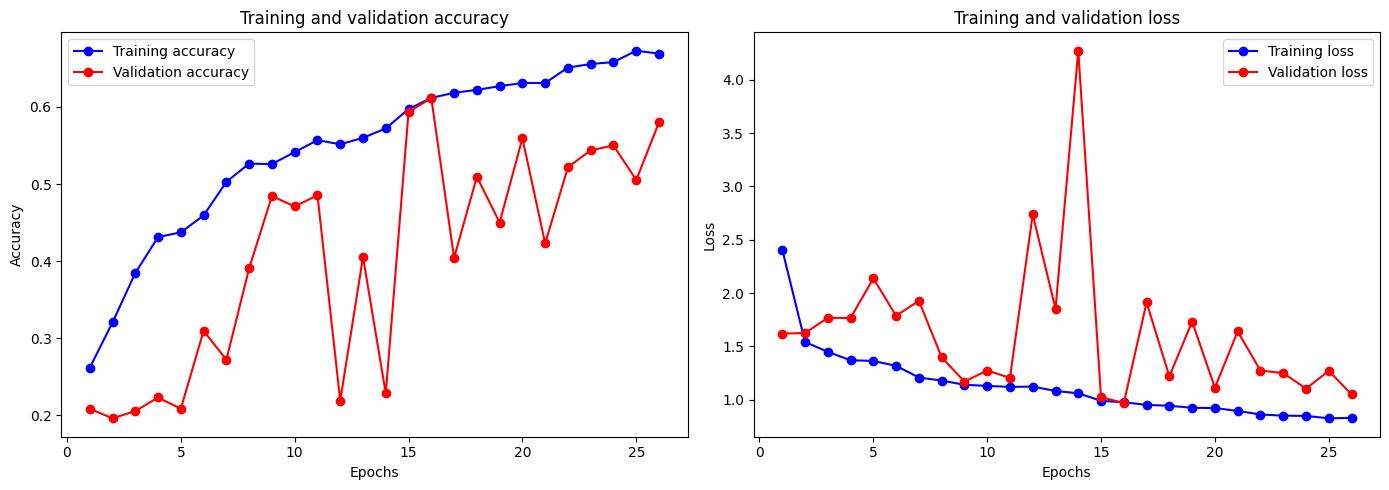

In [ ]:
# Đánh giá mô hình trên tập dữ liệu kiểm thử
loss, accuracy = model.evaluate(validation_generator)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Lấy lịch sử huấn luyện
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Vẽ đồ thị lịch sử huấn luyện accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ đồ thị lịch sử huấn luyện loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
validation_generator.reset()
test_predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = validation_generator.classes

# Tạo confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Hiển thị confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
cmd.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal')
plt.title('Confusion Matrix')
plt.show()

###4.3.4. RMSprop

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
62/62 [==============================] - 44s 197ms/step - loss: 2.3020 - accuracy: 0.2391 - val_loss: 1.6128 - val_accuracy: 0.1990 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 11s 175ms/step - loss: 1.5178 - accuracy: 0.3153 - val_loss: 1.6284 - val_accuracy: 0.2010 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 10s 168ms/step - loss: 1.4532 - accuracy: 0.3758 - val_loss: 1.7091 - val_accuracy: 0.2073 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 10s 156ms/step - loss: 1.3934 - accuracy: 0.4068 - val_loss: 1.8134 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 11s 174ms/step - loss: 1.3297 - accuracy: 0.4477 - val_loss: 1.6714 - val_accuracy: 0.2271 - lr: 0.0010
Epoch 6/50
62/62 [==============================] - 11s 169ms/step - loss: 1.2939 - accuracy: 0.4654 - val_loss: 1.6152 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 7/50
62/62 [==============================] - 11s 183ms/st

16/16 [==============================] - 2s 107ms/step - loss: 0.9661 - accuracy: 0.5840
Test accuracy: 58.40%


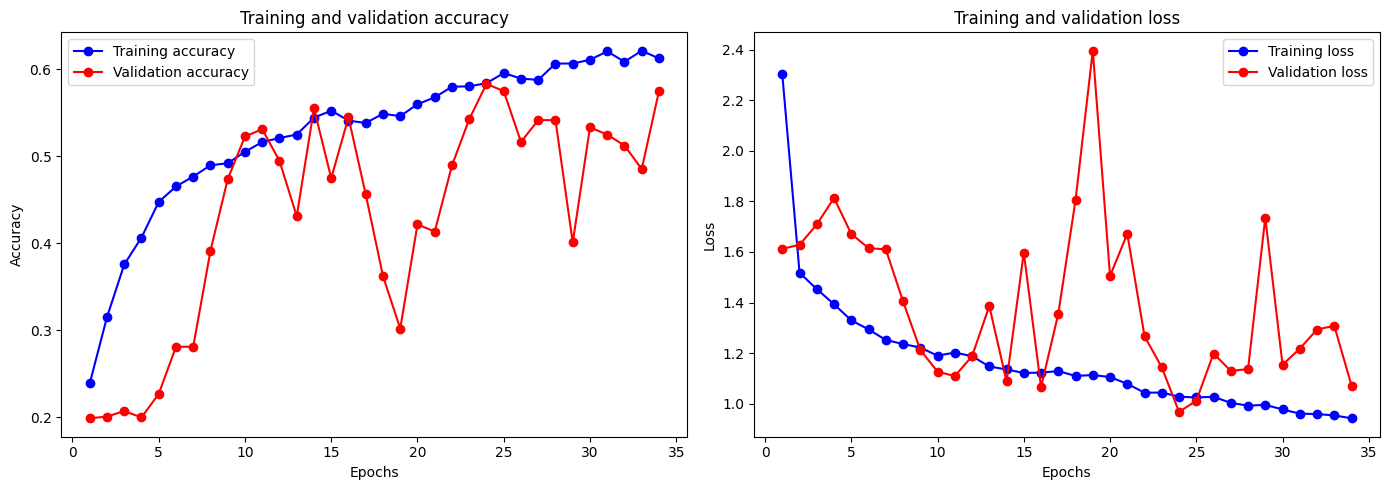

In [ ]:
# Đánh giá mô hình trên tập dữ liệu kiểm thử
loss, accuracy = model.evaluate(validation_generator)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Lấy lịch sử huấn luyện
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Vẽ đồ thị lịch sử huấn luyện accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ đồ thị lịch sử huấn luyện loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

16/16 [==============================] - 3s 119ms/step


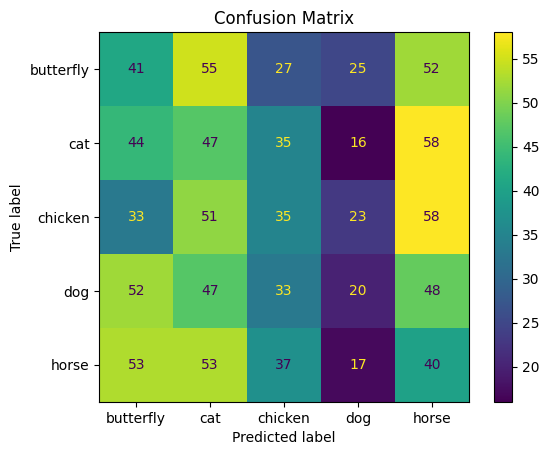

In [ ]:
validation_generator.reset()
test_predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = validation_generator.classes

# Tạo confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Hiển thị confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
cmd.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal')
plt.title('Confusion Matrix')
plt.show()

###4.3.5. Adam

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
# Đánh giá mô hình trên tập dữ liệu kiểm thử
loss, accuracy = model.evaluate(validation_generator)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Lấy lịch sử huấn luyện
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Vẽ đồ thị lịch sử huấn luyện accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ đồ thị lịch sử huấn luyện loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
validation_generator.reset()
test_predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = validation_generator.classes

# Tạo confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Hiển thị confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
cmd.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal')
plt.title('Confusion Matrix')
plt.show()

###4.3.6. Nadam

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Nadam(learning_rate=learning_rate),
    metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
62/62 [==============================] - 1393s 21s/step - loss: 2.2496 - accuracy: 0.2508 - val_loss: 1.6146 - val_accuracy: 0.1990 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 24s 392ms/step - loss: 1.6199 - accuracy: 0.3351 - val_loss: 1.6099 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 24s 395ms/step - loss: 1.4399 - accuracy: 0.3763 - val_loss: 1.6134 - val_accuracy: 0.1917 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 25s 396ms/step - loss: 1.3849 - accuracy: 0.4233 - val_loss: 1.6286 - val_accuracy: 0.2135 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 24s 394ms/step - loss: 1.3648 - accuracy: 0.4324 - val_loss: 1.5539 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 6/50
62/62 [==============================] - 24s 390ms/step - loss: 1.3166 - accuracy: 0.4466 - val_loss: 1.8053 - val_accuracy: 0.2479 - lr: 0.0010
Epoch 7/50
62/62 [==============================] - 24s 391ms/st

16/16 [==============================] - 9s 523ms/step - loss: 1.6096 - accuracy: 0.2000
Test accuracy: 20.00%


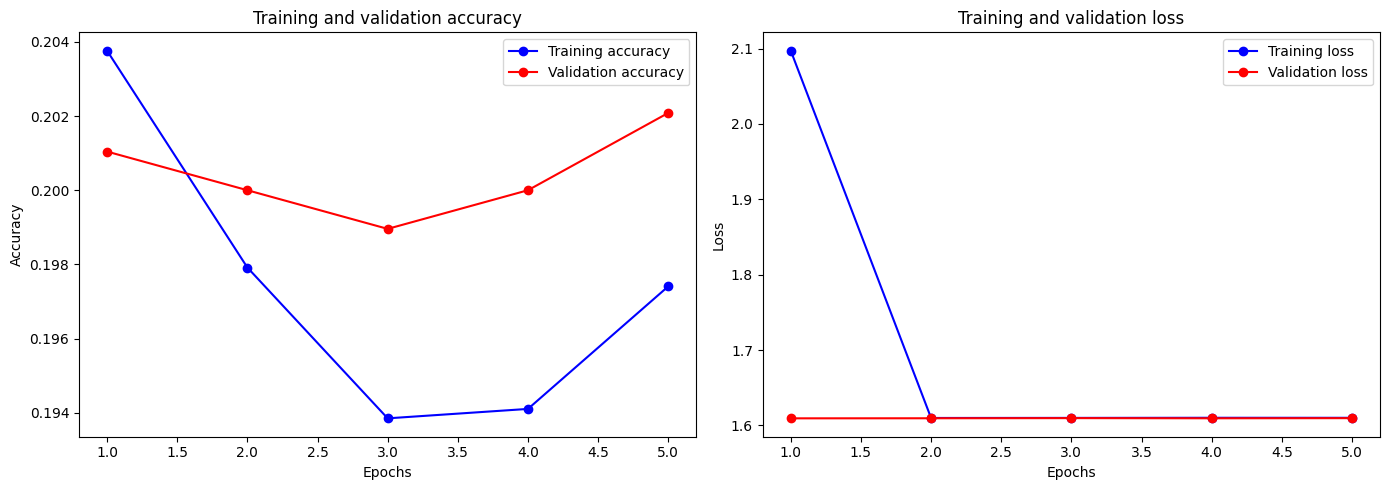

In [ ]:
# Đánh giá mô hình trên tập dữ liệu kiểm thử
loss, accuracy = model.evaluate(validation_generator)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Lấy lịch sử huấn luyện
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Vẽ đồ thị lịch sử huấn luyện accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ đồ thị lịch sử huấn luyện loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

16/16 [==============================] - 10s 479ms/step


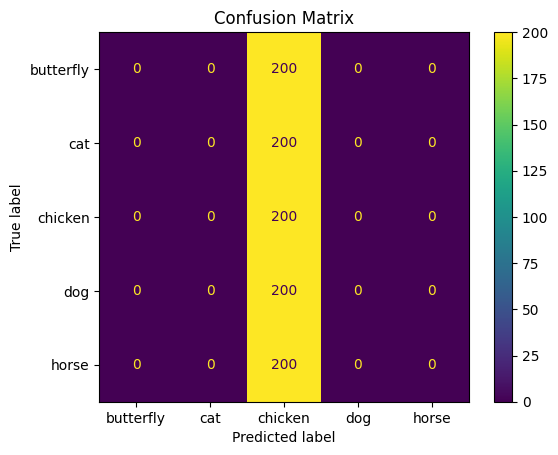

In [ ]:
validation_generator.reset()
test_predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = validation_generator.classes

# Tạo confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Hiển thị confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
cmd.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal')
plt.title('Confusion Matrix')
plt.show()

#In ảnh sai nhãn

16/16 [==============================] - 8s 509ms/step


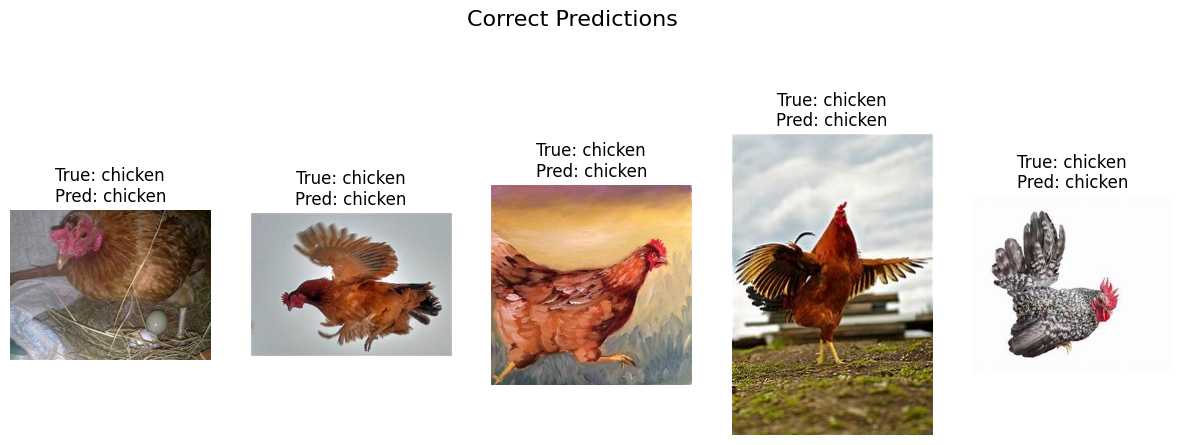

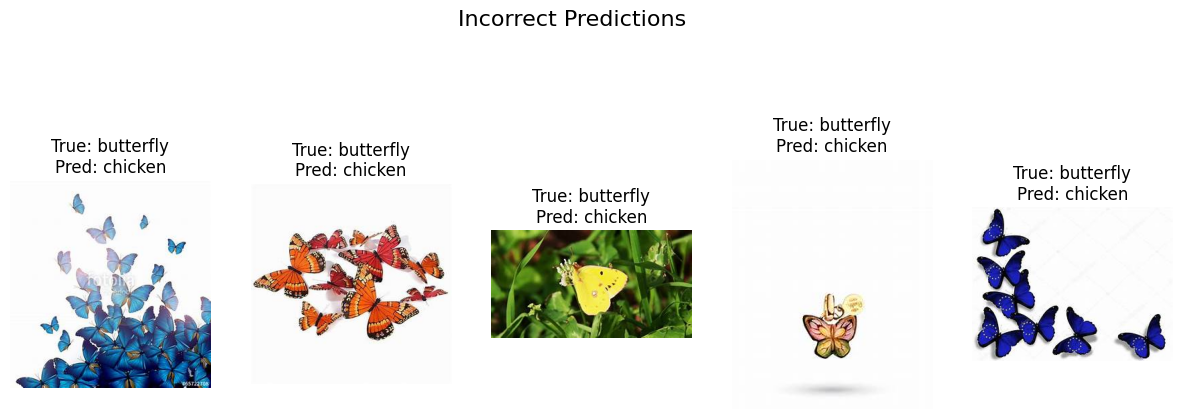

In [ ]:
# Reset lại generator để đảm bảo bắt đầu từ đầu
validation_generator.reset()

# Dự đoán nhãn cho tập dữ liệu kiểm thử
test_predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Lấy nhãn thực từ generator
test_true_labels = validation_generator.classes

# Lấy tên lớp từ generator
class_labels = list(validation_generator.class_indices.keys())

# Lấy đường dẫn ảnh từ generator
test_filepaths = validation_generator.filepaths

# Tìm các ảnh đúng và sai
correct_indices = np.where(test_predicted_labels == test_true_labels)[0]
incorrect_indices = np.where(test_predicted_labels != test_true_labels)[0]

# Hiển thị ảnh với nhãn dự đoán đúng
def plot_images(indices, title):
    plt.figure(figsize=(15, 10))
    for i, index in enumerate(indices[:5]):  # Hiển thị tối đa 10 ảnh
        ax = plt.subplot(2, 5, i + 1)
        img = plt.imread(test_filepaths[index])
        plt.imshow(img)
        plt.title(f"True: {class_labels[test_true_labels[index]]}\nPred: {class_labels[test_predicted_labels[index]]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Hiển thị các ảnh dự đoán đúng
plot_images(correct_indices, "Correct Predictions")

# Hiển thị các ảnh dự đoán sai
plot_images(incorrect_indices, "Incorrect Predictions")